In [4]:
import os
from datetime import datetime
from dateutil.parser import parse
import time

import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.optimize import curve_fit
import scipy.stats as scs
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pprint import pprint
from tqdm import tqdm

import seaborn as sns
sns.set_theme(style="whitegrid")

from src.nft_analytics import NFTAnalytics
from src.ethereum_api import EthereumAPI

In [5]:
cbd = NFTAnalytics("0xe12EDaab53023c75473a5A011bdB729eE73545e8")
DATA_FOLDER, RESULT_FOLDER = cbd.make_directories("ChibiDinos")
TIMESTAMP = datetime.now().strftime("%Y-%m-%d_")
#TIMESTAMP = "2021-09-16_"

2021-10-19 22:34:05,154 - src.ethereum_api - INFO - Connected to Infura endpoint.


In [3]:
asset_data = cbd.fetch_data(max_offset=10000)
cbd.save_json(asset_data, filename=os.path.join(DATA_FOLDER, "data.json"))

10000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [05:03<00:00,  1.51s/it]


2021-10-19 22:14:58,400 - src.nft_analytics - INFO - Saved asset data to data\ChibiDinos\data.json


In [6]:
asset_data = cbd.load_json(filename=os.path.join(DATA_FOLDER, "data.json"))
OPENSEA_FLOOR_PRICE = 0.09 # cbd.get_floor_price(asset_data)

# Listing Prices

In [ ]:
created_dates = []
listing_prices = []
for asset in asset_data:
    if asset["sell_orders"]:
        created_dates.append(parse(asset["sell_orders"][0]["created_date"]))
        listing_prices.append(float(asset["sell_orders"][0]["base_price"]) / 1e18)
listing_prices = np.array(listing_prices)

In [ ]:
fig, ax = plt.subplots()

dates = matplotlib.dates.date2num(created_dates)
ax.plot_date(dates, listing_prices, 'o', alpha=0.2)
fig.autofmt_xdate()
ax.set_ylim(-0.01, OPENSEA_FLOOR_PRICE * 3)
ax.set_ylabel("Listing Price (ETH)")
ax.axhline(OPENSEA_FLOOR_PRICE, color="tab:orange", linestyle="--", label=f"Floor = {OPENSEA_FLOOR_PRICE:.2f} ETH")
ax.set_title("Listing price with time")
ax.grid(True, linestyle="--")
ax.set_yticks(ax.get_yticks()[::2])

ax.legend()

fig.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "listing_price_variation_with_time_near_floor.jpg"), bbox_inches="tight", dpi=600)

In [ ]:
# Cost to cleanup sub-floor
np.sum(listing_prices[listing_prices < OPENSEA_FLOOR_PRICE])

# Histogram of listing prices

In [ ]:
upper_limit = 3

fig, ax = plt.subplots()
_, bins, _ = ax.hist(listing_prices, histtype='stepfilled', density=True, bins=100, range=[0, upper_limit], alpha=0.5)

params = scs.lognorm.fit(listing_prices[listing_prices < upper_limit])
x_bins = np.linspace(1e-2, np.max(listing_prices[listing_prices < upper_limit]), len(bins)*100) 
ax.plot(x_bins, scs.lognorm.pdf(x_bins, *params), linewidth=2, label=f"Lognormal distribution")
ax.set_title(f"Lognormal mean listing price = {params[2]:.2f} ETH")

ax.set_xlabel("Listing Price (ETH)")
ax.set_ylabel("No. of listings (norm.)")
ax.legend()
ax.grid(True, linestyle="--")
#ax.set_xscale("log")
fig.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "histogram_listing_price_variation_near_floor.jpg"), bbox_inches="tight", dpi=600)

# Sale price with time

In [ ]:
sale_prices = []
timestamps = []

for asset in asset_data:
    if asset["last_sale"]:
        if asset["last_sale"]["event_type"] == "successful":
            timestamps.append(parse(asset["last_sale"]["transaction"]["timestamp"]))
            sale_prices.append(float(asset["last_sale"]["total_price"]) / 1e18)
            
sale_prices = np.array(sale_prices)

In [ ]:
fig, ax = plt.subplots()

dates = matplotlib.dates.date2num(timestamps)
ax.plot_date(dates, sale_prices, 'o', alpha=0.2)
fig.autofmt_xdate()

ax.set_ylim(-0.01, 0.3)
ax.set_ylabel("Sale Price (ETH)")
ax.axhline(OPENSEA_FLOOR_PRICE, color="tab:orange", linestyle="--", label=f"Floor = {OPENSEA_FLOOR_PRICE:.2f} ETH")
ax.set_title("Sale price with time")
ax.grid(True, linestyle="--")
ax.legend()

fig.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "sale_price_variation_with_time_near_floor.jpg"), bbox_inches="tight", dpi=600)

# Histogram of sale

In [ ]:
df = pd.DataFrame(columns=["Date", "Sales"])

df["Date"] = sorted(timestamps)
df["Sales"] = np.ones(len(timestamps))
df = df.groupby(df['Date'].dt.date).sum()

In [ ]:
upper_limit = 1

fig, ax = plt.subplots()

unix_timestamps = []

for times in timestamps:
    unix_timestamps.append(times.timestamp())

mpl_data = mdates.epoch2num(unix_timestamps)
_, bins, _ = ax.hist(mpl_data, bins=len(df["Sales"]), alpha=0.3)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
ax.set_ylabel("Number of sales")
ax.grid(True, linestyle="--")
#ax.axhline(df["Sales"].median(), color="tab:green", linestyle="--", label="Average sales")
ax.plot(df["Sales"].rolling(window=5).mean(), label="5 day MA")
ax.plot(df["Sales"].rolling(window=20).mean(), label="20 day MA")


ax.set_yscale("log")
ax.legend()

delta = (df['Sales'][-5:].mean() - df['Sales'][-20:].mean()) / df['Sales'][-20:].mean() * 100
if delta > 0:
    ax.set_title(f"Last 5 days sales up {abs(delta):.1f}% from average sales")
else:
    ax.set_title(f"Last 5 days sales down {abs(delta):.1f}% from average sales")

fig.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "histogram_number_of_sales_with_time.jpg"), bbox_inches="tight", dpi=600)

In [ ]:
df.to_excel(os.path.join(RESULT_FOLDER, TIMESTAMP + "sales_by_day.xlsx"), index=True)

# Chibi Dinos and ETH holdings by address (OpenSea API + Infura)

In [ ]:
df = cbd.get_nft_holdings(asset_data, "ChibiDinos", eth_balances=True)

In [ ]:
df = df.sort_values("ChibiDinos", ascending=False)

In [ ]:
df.to_excel(os.path.join(RESULT_FOLDER, TIMESTAMP + "chibidinos_holders_addresses_holdings_and_balances.xlsx"), index=False)

In [ ]:
df = pd.read_excel(os.path.join(RESULT_FOLDER, TIMESTAMP + "chibidinos_holders_addresses_holdings_and_balances.xlsx"))

In [ ]:
df.sort_values("ETH_balance", ascending=False)

# ChibiDinos in wallet

In [ ]:
fig, ax = plt.subplots()

upper_limit = 15
_, bins, _ = ax.hist(df["ChibiDinos"], density=False, bins=upper_limit, alpha=0.5, range=[0, upper_limit])

ax.set_ylabel("No. of wallets")
#ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel("Chibi Dinos in wallet")

median_holding = np.median(df['ChibiDinos'])
max_holding = np.max(df['ChibiDinos'])

chibis = 5
ax.set_title(f"ChibiDino holdings\nMedian = {int(median_holding)}, Max = {int(max_holding)}, {len(df['ChibiDinos'][df['ChibiDinos'] < chibis]) / len(df['ChibiDinos']) * 100:.1f}% under {chibis} Chibis")

fig.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "chibi_dinos_in_wallets.jpg"), bbox_inches="tight", dpi=600)

# ETH in wallet

In [ ]:
fig, ax = plt.subplots()

upper_limit = 100

_, bins, _ = ax.hist(df["ETH_balance"], density=False, bins=100, alpha=0.5, range=[0, upper_limit], )

print(f"Under {upper_limit} ETH = {len(df['ETH_balance'][df['ETH_balance'] < upper_limit]) / len(df['ETH_balance']) * 100:.2f}%")
print(f"Over {upper_limit} ETH = {len(df['ETH_balance'][df['ETH_balance'] > upper_limit]) / len(df['ETH_balance']) * 100:.2f}%")

ax.set_ylabel("No. of wallets")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("ETH in wallet")

median_holding = np.median(df['ETH_balance'])
max_holding = np.max(df['ETH_balance'])
ax.set_title(f"ChibiDinos holders ETH balance\nMedian = {median_holding:.2f} ETH, Max = {max_holding:.2f} ETH")

fig.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "eth_in_holder_wallets.jpg"), bbox_inches="tight", dpi=600)

# Variation of bid price with time

In [ ]:
events_data = cbd.fetch_events(max_offset=10000)
cbd.save_json(events_data, filename=os.path.join(DATA_FOLDER, "events.json"))

In [ ]:
events_data = cbd.load_json(filename=os.path.join(DATA_FOLDER, "events.json"))

In [ ]:
bids = []
created_dates = []

for event in events_data:
    if event["bid_amount"]:
        created_dates.append(parse(event["created_date"]))
        bids.append(float(event["bid_amount"]) / 1e18)
bids = np.array(bids)

In [ ]:
fig, ax = plt.subplots()
#ax.set_yscale("log")
dates = matplotlib.dates.date2num(created_dates)
ax.plot_date(dates, bids, 'o', alpha=0.4)
fig.autofmt_xdate()
ax.set_ylabel("Bid Price (ETH)")
ax.axhline(OPENSEA_FLOOR_PRICE, color="tab:orange", linestyle="--", label=f"OpenSea floor = {OPENSEA_FLOOR_PRICE:.2f} ETH")
ax.legend()
ax.set_ylim(-0.01, OPENSEA_FLOOR_PRICE * 10)
ax.set_title(f"Variation of bids with time (Bids under floor = {len(bids[bids < OPENSEA_FLOOR_PRICE]) / len(bids) * 100:.1f}%)")
ax.grid(True, linestyle="--")

fig.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "bid_price_variation_with_time.jpg"), bbox_inches="tight", dpi=600)

# Number per price range

In [7]:
created_dates = []
listing_prices = []
for asset in asset_data:
    if asset["sell_orders"]:
        created_dates.append(parse(asset["sell_orders"][0]["created_date"]))
        listing_prices.append(float(asset["sell_orders"][0]["base_price"]) / 1e18)
listing_prices = np.array(listing_prices)

[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19]
[0.09 0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18]


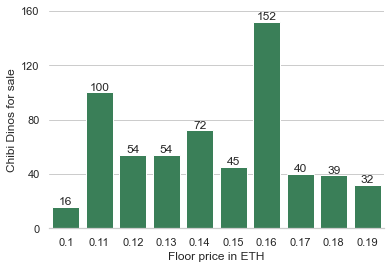

In [56]:
OPENSEA_FLOOR_PRICE = round(OPENSEA_FLOOR_PRICE, 2)

numbers_in_bins = []

price_bins = np.arange(0.1, 0.2, 0.01)
differential = 0.01
print(price_bins)
print(price_bins - differential)
last_bin = 0
for current_bin in price_bins:
    number_in_bin = len(listing_prices[(listing_prices < current_bin) & (listing_prices >= (current_bin - differential))])
    last_bin = current_bin
    numbers_in_bins.append(round(number_in_bin, 2))

price_bins_rounded = np.around(price_bins, 2)

ax = sns.barplot(x=price_bins_rounded, y=numbers_in_bins, color="seagreen")
ax.bar_label(ax.containers[0])
sns.despine(left=True)
ax.set_yticks(ax.get_yticks()[::2])
ax.set_xlabel("Floor price in ETH")
ax.set_ylabel("Chibi Dinos for sale")
ax.figure.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "chibi_dinos_floor_sale.jpg"), dpi=600)

In [22]:
38 + 157 + 27 + 51 + 26 + 45

344

# IQ

In [ ]:
assets_with_sells = 0
for asset in asset_data:
    if asset["sell_orders"]:
        assets_with_sells += 1

iqs = np.ones(assets_with_sells, dtype="int") * 19
listing_prices = np.zeros(assets_with_sells)

idx = 0
for asset in asset_data:
    if asset["sell_orders"]:
        for trait in asset["traits"]:
            if trait["trait_type"] == "IQ":
                listing_prices[idx] = float(asset["sell_orders"][0]["base_price"]) / 1e18
                iqs[idx] = int(trait["value"])
        idx += 1

In [ ]:
_iq = {}

for asset in asset_data:
    if asset["sell_orders"]:
        for trait in asset["traits"]:
            if trait["trait_type"] == "IQ":
                _iq[int(trait["value"])] = []
                
for asset in asset_data:
    if asset["sell_orders"]:
        for trait in asset["traits"]:
            if trait["trait_type"] == "IQ":
                _iq[int(trait["value"])].append(float(asset["sell_orders"][0]["base_price"]) / 1e18)

In [ ]:
def x3_func(x, a, b, c):
    return a + b * (x - c)**3

In [ ]:
popt, pcov = curve_fit(x3_func, xdata=np.arange(0, len(iqs)), ydata=np.sort(iqs))

In [ ]:
fig, ax = plt.subplots()
#ax.plot(np.sort(iqs))

spl = interpolate.UnivariateSpline(np.arange(0, len(iqs)), np.sort(iqs), k=5, s=500)
interp_x = np.linspace(0, len(iqs), 500)
ax.plot(interp_x, spl(interp_x))

val = 50
res = np.interp(val, np.sort(iqs), np.arange(0, len(iqs)))
ax.plot(res, val+1, markersize=10, marker="o")

#ax.plot(np.arange(0, len(iqs)), x3_func(np.arange(0, len(iqs)), *popt))
ax.set_xlabel("Index")
ax.set_ylabel("IQ")

lower, mid_lower, mid_upper, upper= 30, 45, 65, 80
ax.axhspan(upper, np.max(iqs), alpha=0.2, color='C2', label="Genius IQ")
ax.axhspan(mid_upper, upper, alpha=0.2, color='C4', label="High IQ")
ax.axhspan(mid_lower, mid_upper, alpha=0.2, color='C5', label="Average IQ")
ax.axhspan(lower, mid_lower, alpha=0.2, color='C1', label="Below average IQ")
ax.axhspan(np.min(iqs), lower, alpha=0.2, color='C3', label="Low IQ")
ax.grid(False)
fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5))
sns.despine(bottom=True, left=True)
ax.set(xlabel=None)
ax.set(xticklabels=[])
ax.set_title("IQ curve")

fig.savefig(os.path.join(RESULT_FOLDER, "IQ_curve.jpg"), dpi=600, bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.sort(iqs), listing_prices[np.argsort(iqs)], ".")
ax.set_ylim([1e-3, 1e4])
ax.set_yscale("log")
ax.set_xlabel("IQ")
ax.set_ylabel("Listing Price")

In [ ]:
np.corrcoef(np.sort(iqs), listing_prices[np.argsort(iqs)])

In [ ]:
def x2func(x, a, b, c):
    return a + b * x + c * x**2

def exp(x, a, b, c):
    return a + b * np.exp(c * x)

In [ ]:
for key, value in _iq.items():
    _iq[key] = np.median(value)

In [ ]:
iq2 = np.array(list(_iq.items()))[:, 0]
prices2 = np.array(list(_iq.items()))[:, 1]

In [ ]:
popt, pcov = curve_fit(x2func, xdata=np.sort(iq2), ydata=prices2[np.argsort(iq2)])

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.sort(iq2), prices2[np.argsort(iq2)], ".")
#ax.plot(np.sort(iq2), exp(np.sort(iq2), *popt))
ax.set_ylim([1e-2, 5e2])
ax.set_yscale("log")

ax.set_ylabel("Median listing prices")
ax.set_xlabel("IQ")

ax.figure.savefig(os.path.join(RESULT_FOLDER, TIMESTAMP + "IQ_with_listing_price.jpg"), dpi=600)

In [ ]:
np.corrcoef(np.sort(iq2), prices2[np.argsort(iq2)])